<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/Traitement_du_langage_naturel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import re

In [1]:
#Download IMDB to the current folder
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip
!tar zxf aclImdb_v1.tar.gz
# aclImdb / train / unsup is unlabeled and removed
!rm -rf aclImdb/train/unsup
# Show IMDB dataset description
!cat aclImdb/README

--2022-04-29 14:00:35--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  1.09MB/s    in 2m 0s   

2022-04-29 14:02:36 (683 KB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an ad

In [3]:
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# Display of the correspondence between 0, 1 of the label and the meaning
print(train_review.target_names)

['neg', 'pos']


In [4]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


In [5]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [6]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [7]:
# Specify the range of n-gram used in ngram_range
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


## [Problem 1] Implémentation Scratch de BoW

### TF-IDF

In [8]:
first_line = 'This movie is SOOOO funny!!!'.lower().replace('!', '').split()
second_line = 'What a movie! I never'.lower().replace('!', '').split()
third_line = 'best movie ever!!!!! this movie'.lower().replace('!', '').split()

In [10]:
gram_1_feature_names = first_line + second_line + third_line

In [11]:
gram_1 = pd.DataFrame(np.zeros((3, len(set(gram_1_feature_names)))).astype('int'), columns=set(gram_1_feature_names))

for i, ss in enumerate([first_line, second_line, third_line]):
    for s in ss:
        n = ss.count(s)
        gram_1[s][i] = n

gram_1

,i,ever,funny,this,movie,is,what,a,best,soooo,never
0,0,0,1,1,1,1,0,0,0,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,0,1,2,0,0,0,1,0,0


In [12]:
gram_2_feature_names = []
gram_2_lines = []
for i, s in enumerate([first_line, second_line, third_line]):
  line = []
  for ss in range(len(s)-1):
    line.append(f'{s[ss]} {s[ss+1]}')
    gram_2_feature_names.append(f'{s[ss]} {s[ss+1]}')
  gram_2_lines.append(line)

In [13]:
gram_2 = pd.DataFrame(np.zeros((3, len(set(gram_2_feature_names)))).astype('int'), columns=set(gram_2_feature_names))

for i, ss in enumerate(gram_2_lines):
    for s in ss:
        n = ss.count(s)
        gram_2[s][i] = n
        
gram_2

,movie i,soooo funny,ever this,a movie,this movie,i never,movie ever,movie is,is soooo,best movie,what a
0,0,1,0,0,1,0,0,1,1,0,0
1,1,0,0,1,0,1,0,0,0,0,1
2,0,0,1,0,1,0,1,0,0,1,0


### IDF

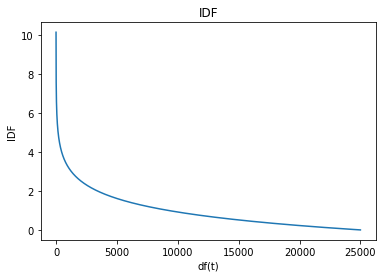

In [14]:
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [15]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [16]:
# Download Stopword for the first time
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

In [17]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## [Problème 2] Calcule TF-IDF

In [18]:
vectorizer = TfidfVectorizer(stop_words= stop_words, max_features=5000)
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.fit_transform(x_test)
print(X_train.shape, X_test.shape)

(25000, 5000) (25000, 5000)


## [Problem 3] Learning avec TF-IDF

In [19]:
lgb = lgb.LGBMClassifier().fit(X_train,y_train)
y_pred = lgb.predict(X_test)

In [20]:
print("{}".format(lgb.score(X_test, y_test)))
print("{}".format(precision_score(y_test,y_pred)))
print("{}".format(recall_score(y_test,y_pred)))
print("{}".format(f1_score(y_test,y_pred)))
print(confusion_matrix(y_test, y_pred))

0.57548
0.5735672514619883
0.58848
0.5809279368213228
[[7031 5469]
 [5144 7356]]


## [Problème 4] Implémentation Scratch de TF-IDF

### formule standard

In [21]:
tf = gram_1.copy()
idf = gram_1.copy()
for i in range(len(tf)):
  tf.iloc[i, :] = tf.iloc[i, :] / tf.iloc[i, :].sum()

for t in idf.columns:
  idf[t][:] = np.log(len(idf.columns) / idf[t].sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
tf

,i,ever,funny,this,movie,is,what,a,best,soooo,never
0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.0
1,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.0,0.0,0.2
2,0.0,0.2,0.0,0.2,0.4,0.0,0.0,0.0,0.2,0.0,0.0


In [23]:
tf * idf

,i,ever,funny,this,movie,is,what,a,best,soooo,never
0,0.000000,0.000000,0.479579,0.34095,0.20232,0.479579,0.000000,0.000000,0.000000,0.479579,0.000000
1,0.479579,0.000000,0.000000,0.00000,0.20232,0.000000,0.479579,0.479579,0.000000,0.000000,0.479579
2,0.000000,0.479579,0.000000,0.34095,0.40464,0.000000,0.000000,0.000000,0.479579,0.000000,0.000000


#### Formule adoptée par scikit-learn

In [24]:
tf_2 = gram_1.copy()
idf_2 = gram_1.copy()

for t in idf.columns:
  idf_2[t][:] = np.log((1 + len(idf.columns)) / (1 + idf[t].sum())) + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
tf_2 * idf_2

,i,ever,funny,this,movie,is,what,a,best,soooo,never
0,0.000000,0.000000,1.381543,1.674285,2.089949,1.381543,0.000000,0.000000,0.000000,1.381543,0.000000
1,1.381543,0.000000,0.000000,0.000000,2.089949,0.000000,1.381543,1.381543,0.000000,0.000000,1.381543
2,0.000000,1.381543,0.000000,1.674285,4.179898,0.000000,0.000000,0.000000,1.381543,0.000000,0.000000


In [26]:
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # Set the number of dimensions to 10
model.build_vocab(sentences) # Preparation
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) #Learning

print("List of vocabulary : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("Vector of {}: \n{}".format(vocab, model.wv[vocab]))

List of vocabulary : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
Vector of this: 
[ 0.0281102  -0.01048526 -0.04529933 -0.01433664  0.03285149 -0.00505815
  0.04123403 -0.0062663  -0.02324758 -0.03351161]
Vector of movie: 
[-0.03382815  0.02478257  0.02343418  0.04686151  0.04018062  0.0376312
  0.02623364 -0.03382969 -0.01064047  0.022363  ]
Vector of is: 
[-0.02207343  0.01648091  0.01004314  0.00399823  0.00968252 -0.02682392
  0.00772287  0.03034711 -0.03582342  0.01320071]
Vector of very: 
[ 0.04139646 -0.03844217  0.0015832  -0.0386744   0.0429057   0.01355737
 -0.04480821 -0.0078843   0.02878687 -0.04935753]
Vector of good: 
[-0.01705237  0.02849923  0.01811331  0.03639222  0.0204739  -0.02721366
 -0.01205959 -0.01172025  0.03807713  0.0177145 ]
Vector of film: 
[-0.01570834 -0.01401624 -0.04873927 -0.00478169 -0.00833456 -0.03565729
  0.01666913  0.03592698 -0.01317324  0.04438463]
Vector of a: 
[ 0.03550179 -0.00982224 -0.03059108  0.04031517  0.0429

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


In [27]:
model.wv.most_similar(positive="good", topn=3)

[('movie', 0.42557239532470703),
 ('a', 0.21185681223869324),
 ('is', 0.1053786426782608)]

#### Visualisation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


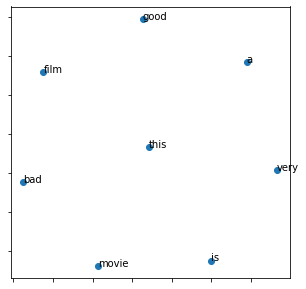

In [28]:
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

Représentation distribuée d'ensembles de données de critiques de films IMDB



In [29]:
model_2 = Word2Vec(min_count=1, size=10) # Set the number of dimensions to 10
model_2.build_vocab(x_train) # Preparation
model_2.train(x_train, total_examples=model_2.corpus_count, epochs=model_2.iter) #Learning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(36007334, 165633705)

### [Problème 5] Prétraitement du corpus

In [33]:
with_url = 0
for i, s in enumerate(x_train):
    if 'www' in s:
      with_url = i
      print('avant processing')
      print('-----')
      print(s)
      break

avant processing
-----
I don't hand out "ones" often, but if there was ever a film that deserved this sort of attention, it's "Gas!" This is self-indulgent crap that reaches for some of the ambiance of M*A*S*H and falls completely flat on its face in the attempt.<br /><br />I see what Corman was going for - Malcolm Marmorstein and Elliott Gould tried to reproduce Gould's deathless role in the original movie version of M*A*S*H with a similar plot (in the movie "Whiffs" - look it up here in IMDb, http://www.imdb.com/title/tt0073891/ for more information).<br /><br />Marmorstein and Gould got closer to the brass ring with "Whiffs" than Corman did with "Gas!" but didn't quite get there. Neither one of those films even got close to the success of M*A*S*H.<br /><br />What's wrong with "Gas!"? What isn't? No one comes close to really acting at a level above junior high school theatrics. The production values stink. Someone else here mentioned the magically regenerating headlights on a getaway

In [34]:
no_preprocessing = x_train[with_url]
after_preprocessing1 = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", no_preprocessing) 
after_preprocessing2 = re.sub(r'<[^>]+>', " ", after_preprocessing1) 
after_preprocessing3 = re.sub(r"[^0-9a-zA-Z ]", "", after_preprocessing2) 
after_preprocessing = after_preprocessing3.lower() 
print('apres processing')
print('-----')
print(after_preprocessing)

apres processing
-----
i dont hand out ones often but if there was ever a film that deserved this sort of attention its gas this is selfindulgent crap that reaches for some of the ambiance of mash and falls completely flat on its face in the attempt  i see what corman was going for  malcolm marmorstein and elliott gould tried to reproduce goulds deathless role in the original movie version of mash with a similar plot in the movie whiffs  look it up here in imdb  for more information  marmorstein and gould got closer to the brass ring with whiffs than corman did with gas but didnt quite get there neither one of those films even got close to the success of mash  whats wrong with gas what isnt no one comes close to really acting at a level above junior high school theatrics the production values stink someone else here mentioned the magically regenerating headlights on a getaway car and theres more of that lack of attention to detail nothing works the way its supposed to in this film and 

## [Problème 6] Apprentissage de Word2Vec


In [35]:
model = Word2Vec(min_count=1, size=10) 
model.build_vocab(after_preprocessing) 
model.train(after_preprocessing, total_examples=model.corpus_count, epochs=model.iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(1390, 8460)